<a href="https://colab.research.google.com/github/MahfuzurRahmanMiah/Specialization/blob/master/Amazon_Reviews_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Analyzing/Predicting Sentiment From Amazon Reviews

For this exercise, let's go back to the sentiment analysis we did earlier in the course - specifically, the Amazon reviews dataset.

It's important to start with a clear goal in mind. In this case, we'd like to determine if we can __predict whether a review is positive or negative based on the language in the review.__

We're going to tackle this problem with Spark - so you'll need to apply the principles you've learned thus far in the context of Spark.

Some tips to help you get started:
1. Pyspark always needs to point at a running Spark instance. You can do that using a `SparkContext`.
2. We're still working in batch mode, so you'll need to load an entire file into memory in order to run any models you build.
3. Spark likes to execute models in a pipeline, so remember that when the time comes to set up your model.
4. Spark's machine learning algorithms expect numeric variables.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [4]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 217.8MB 61kB/s 
     |████████████████████████████████| 204kB 51.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=e607e30ba360b70d243153db4647d66c57e4edd891121f729f589853f5941b93
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [11]:
# Point Colaboratory to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# load dependencies
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

# these imports are how we build and manager our data science processes: cleaning data, preparing a model,
# executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [0]:
# we use a set of constants for clarity and simplicity in managing the notebook.
# refer back to this cell to confirm or modify any of these values.

JSON_PATH = "/content/gdrive/My Drive/Colab Datasets/AmznInstantVideo.json" 
APP_NAME = "Sentiment Analysis with Amazon Reviews Exercise"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
#Change ratio to .7
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

The first thing we always do is create a `SparkContext`, and then immediately afterward create a `sqlContext` to be able to load and manipulate an RDD/dataframe.

In [0]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

Now that we've connected to Spark and have a sqlContext ready, it's time to load our data. 

In [0]:
amznInstantVideo = sqlContext.read.json(JSON_PATH)

Let's check the shape of the dataset, and review the schema so we see what we're dealing with.

In [17]:
print(f"Dataset shape is {amznInstantVideo.count():d} rows by {len(amznInstantVideo.columns):d} columns.")

Dataset shape is 37121 rows by 9 columns.


In [18]:
amznInstantVideo.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



From the schema, we are particularly interested in overall, reviewText and summary.

__------------------------__

Before we get going on our data preparation, let's take a look at the columns we mentioned above.

To perform a SQL query on a dataframe, we need to create a `tempTable`.

In [0]:
amznInstantVideo.registerTempTable('reviews')

In [20]:
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()

+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|      20888|
|    4.0|       8445|
|    3.0|       4185|
|    2.0|       1885|
|    1.0|       1718|
+-------+-----------+



We see that most of the reviews are 5-star - so we certainly should recode. For our purposes, we can get closer to a balanced dataset if we recode to >3 is positive, <= 3 is negative. 

It's not totally balanced but we can resample later to get better results.

Let's recode the overall score to __positive__ or __negative__
* __Positive__: overall > 3
* __Negative__: overall <= 3

The easiest path to recoding the data in this fashion is to create a new column, from a User Defined Function.

In [0]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())

amznInstantVideo = amznInstantVideo.withColumn("overall_recode",udf(amznInstantVideo.overall))

This time let's just make a plot of the two labels - so we can see the imbalance.

([<matplotlib.axis.XTick at 0x7f6354a3cda0>,
 <a list of 2 Text xticklabel objects>)

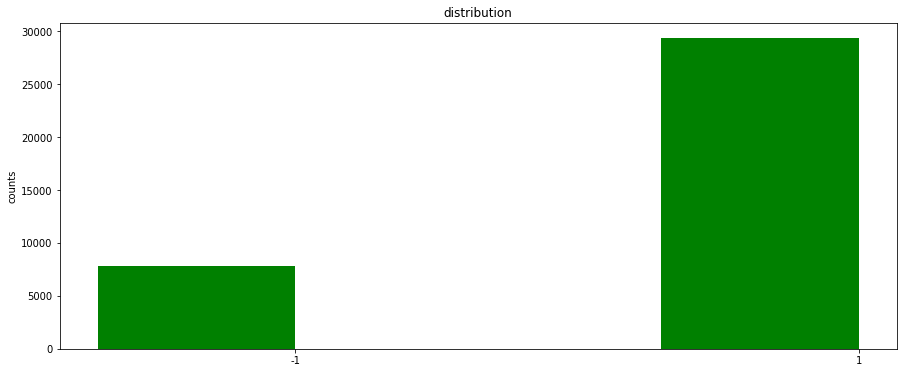

In [24]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = amznInstantVideo.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='g')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

Now it's time to look at the text and encode it into vectors.

First, let's take a look at the relevant columns.

In [25]:
amznInstantVideo.select("overall", "overall_recode", "summary", "reviewText").show(10)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    2.0|            -1|A little bit bori...|I had big expecta...|
|    5.0|             1|Excellent Grown U...|I highly recommen...|
|    1.0|            -1|Way too boring fo...|This one is a rea...|
|    4.0|             1|Robson Green is m...|Mysteries are int...|
|    5.0|             1|Robson green and ...|This show always ...|
|    5.0|             1|I purchased the s...|I discovered this...|
|    3.0|            -1|It takes up your ...|It beats watching...|
|    3.0|            -1|A reasonable way ...|There are many ep...|
|    5.0|             1|           kansas001|This is the best ...|
|    3.0|            -1| Entertaining Comedy|Not bad.  Didn't ...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



For the start of this exercise we'll use only the `reviewText` column; later we could even merge the `summary` and `reviewText` to see if it improves the performance of the classifier.

In [0]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(amznInstantVideo)

word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)

In [0]:
w2vdf.printSchema()

In [0]:
w2vdf.select("overall_recode", "reviewText", "tokenized_text", "w2v_vector").show(10)

Since we have everything in numeric format, let's start with our old standby, the __random forest__. 

Important - note that the data is now in the `w2vdf` object - not the `amznInstantVideo` object.

In [0]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [0]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [0]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Not the best but it is a start. We can try resampling to balance our classes. We can also try different models. 